# **Loading HSI in python**

In [1]:
from PIL import Image
import numpy as np

In [2]:
# Initialize an empty list to store the image data
image_data_list = []

# Loop through the images and convert them to NumPy arrays
for i in range(31):
  # Construct the file name for the current image
  image_file = f'/content/drive/MyDrive/balloons_ms/balloons_ms/balloons_ms_{i+1:02d}.png'

  # Open the image and convert it to a NumPy array
  image = Image.open(image_file)
  image_data = np.array(image)

  # Append the image data to the list
  image_data_list.append(image_data)

# Stack the image data into a 3D array
image_data = np.stack(image_data_list, axis=2)


In [3]:
image_data.shape

(512, 512, 31)

# **GROUND TRUTH DATASET.**

In [4]:

import tensorflow as tf
from tensorflow.keras import layers

gt_data=[]

for i in range(15):

  for j in range(15):
    if j==0 & i==0:
      gt_dataset=image_data[0:63,0:63,0:31]

  # Extract a ROI from the image
    gt_dataset=image_data[j*32:j*32+64,i*32:i*32+64,0:31]
    gt_data.append(gt_dataset)
# Stack the image data into a 3D array
gt_dataset = np.stack(gt_data, axis=2)


In [5]:
gt_dataset.shape

(64, 64, 225, 31)

In [6]:
image_transposed = np.transpose(gt_dataset, (2, 0, 1, 3))

In [7]:
image_transposed.shape

(225, 64, 64, 31)

In [8]:
image_transposed[1].shape

(64, 64, 31)

# **HI RESOLUTION RGB**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layer
input_layer = layers.Input(shape=(64, 64, 31))

# Define the convolutional layer
conv_layer = layers.Conv2D(3, kernel_size=3, padding='same', activation='relu')(input_layer)

# Define the model
model = tf.keras.Model(input_layer, conv_layer)

# Compile the model
HR_RGB = model.predict(image_transposed)

8/8 [==============================] - 7s 11ms/step


In [10]:
HR_RGB.shape

(225, 64, 64, 3)

In [11]:
HR_RGB[0].shape

(64, 64, 3)

# **LOW RESOLUTION HYPERSPECTRAL IMAGES**

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layer
input_layer = layers.Input(shape=(64, 64, 31))

# Define the convolutional layer
conv_layer = layers.Conv2D(31, kernel_size=3, strides=8, padding='same', activation='relu')(input_layer)

# Define the model
model = tf.keras.Model(input_layer, conv_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
LRHSI = model.predict(image_transposed)

8/8 [==============================] - 0s 8ms/step


In [14]:
LRHSI.shape

(225, 8, 8, 31)

In [15]:
LRHSI[0].shape


(8, 8, 31)

# **IMAGE FUSION FOR SUPER RESOLUTION**

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

upsample1 = layers.UpSampling2D(size=1)(input_layer1)

# Define the convolutional layer
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)


# Define the convolutional layer
#conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(input_layer1)

upsample = layers.UpSampling2D(size=8)(input_layer2)

# Define the convolutional layer
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)


# Define the output layer
output_layer = layers.Add()([conv_layer1, conv_layer2 ])

# Define the model
model = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [17]:
import matplotlib.pyplot as plt

# Train the model and store the history object
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=10000, batch_size=None, validation_split=0.2)



Streaming output truncated to the last 5000 lines.
6/6 [==============================] - 0s 33ms/step - loss: 1078571.5000 - accuracy: 0.7259 - val_loss: 757571.7500 - val_accuracy: 0.6797
Epoch 7502/10000
6/6 [==============================] - 0s 32ms/step - loss: 1078573.1250 - accuracy: 0.7259 - val_loss: 757567.1250 - val_accuracy: 0.6949
Epoch 7503/10000
6/6 [==============================] - 0s 39ms/step - loss: 1078574.3750 - accuracy: 0.7206 - val_loss: 757568.5625 - val_accuracy: 0.7025
Epoch 7504/10000
6/6 [==============================] - 0s 38ms/step - loss: 1078575.1250 - accuracy: 0.7222 - val_loss: 757571.1875 - val_accuracy: 0.6551
Epoch 7505/10000
6/6 [==============================] - 0s 30ms/step - loss: 1078574.2500 - accuracy: 0.7278 - val_loss: 757570.7500 - val_accuracy: 0.6998
Epoch 7506/10000
6/6 [==============================] - 0s 33ms/step - loss: 1078573.6250 - accuracy: 0.7251 - val_loss: 757563.1875 - val_accuracy: 0.6892
Epoch 7507/10000
6/6 [========

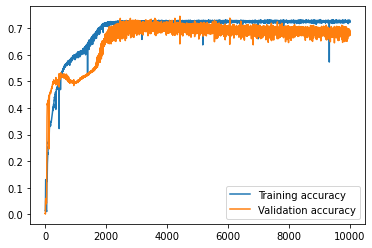

In [18]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')

plt.legend()
plt.show()

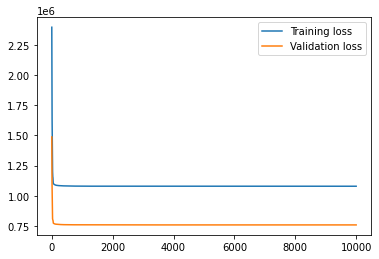

In [19]:

# Plot and loss values

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
# Define the convolutional layer
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)
# Define the convolutional layer
#conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(input_layer1)
upsample = layers.UpSampling2D(size=8)(input_layer2)
# Define the convolutional layer
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)
# Define the output layer
output_layer1 = layers.Add()([conv_layer1, conv_layer2 ])
# Add another convolutional layer
conv_layer3 = layers.Conv2D(64, kernel_size=1, activation='relu')(output_layer1)
# Add a pooling layer
pooling_layer2 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer3)
conv_layer4 = layers.Conv2D(128, kernel_size=1, activation='relu')(pooling_layer2)
# Add a pooling layer
pooling_layer3 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer4)
conv_layer5 = layers.Conv2D(64, kernel_size=1, activation='relu')(pooling_layer3)
# Add a pooling layer
pooling_layer4 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer5)
# Add another convolutional layer
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pooling_layer4)
# Define the model
model = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
import matplotlib.pyplot as plt

# Train the model and store the history object
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=10000, batch_size=None, validation_split=0.2)


Streaming output truncated to the last 5000 lines.
6/6 [==============================] - 0s 45ms/step - loss: 1077989.7500 - accuracy: 0.7690 - val_loss: 757503.9375 - val_accuracy: 0.7127
Epoch 7502/10000
6/6 [==============================] - 0s 46ms/step - loss: 1077988.1250 - accuracy: 0.7735 - val_loss: 757481.7500 - val_accuracy: 0.7361
Epoch 7503/10000
6/6 [==============================] - 0s 43ms/step - loss: 1077996.2500 - accuracy: 0.7728 - val_loss: 757500.0625 - val_accuracy: 0.7168
Epoch 7504/10000
6/6 [==============================] - 0s 51ms/step - loss: 1077990.0000 - accuracy: 0.7756 - val_loss: 757524.6250 - val_accuracy: 0.7024
Epoch 7505/10000
6/6 [==============================] - 0s 54ms/step - loss: 1077987.3750 - accuracy: 0.7715 - val_loss: 757479.3125 - val_accuracy: 0.7288
Epoch 7506/10000
6/6 [==============================] - 0s 51ms/step - loss: 1077981.6250 - accuracy: 0.7733 - val_loss: 757491.8125 - val_accuracy: 0.7159
Epoch 7507/10000
6/6 [========

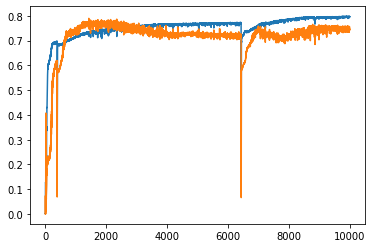

In [22]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()


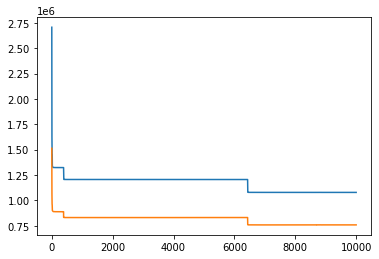

In [23]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [24]:
# Fuse the low-resolution and high-resolution images
fused_image = model.predict([HR_RGB, LRHSI])

8/8 [==============================] - 0s 22ms/step


In [25]:
fused_image.shape

(225, 64, 64, 31)

In [27]:
LOSS=(fused_image-image_transposed)**2
er=LOSS.sum()
print(er/8126464)

175172637.04516962


# **new model with increase layers**

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])


In [38]:
import matplotlib.pyplot as plt

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=2000, batch_size=None, validation_split=0.1)

Epoch 1/200
4/4 [==============================] - 2s 171ms/step - loss: 181782976.0000 - accuracy: 0.0075 - val_loss: 57402548.0000 - val_accuracy: 0.0000e+00
Epoch 2/200
4/4 [==============================] - 0s 45ms/step - loss: 156493920.0000 - accuracy: 0.0020 - val_loss: 47174524.0000 - val_accuracy: 0.0000e+00
Epoch 3/200
4/4 [==============================] - 0s 47ms/step - loss: 128314568.0000 - accuracy: 8.1219e-04 - val_loss: 38205848.0000 - val_accuracy: 2.6537e-04
Epoch 4/200
4/4 [==============================] - 0s 46ms/step - loss: 103601432.0000 - accuracy: 6.2969e-04 - val_loss: 33755920.0000 - val_accuracy: 2.6537e-04
Epoch 5/200
4/4 [==============================] - 0s 47ms/step - loss: 88469224.0000 - accuracy: 6.2727e-04 - val_loss: 30031102.0000 - val_accuracy: 2.6537e-04
Epoch 6/200
4/4 [==============================] - 0s 49ms/step - loss: 75186880.0000 - accuracy: 9.1492e-04 - val_loss: 23069890.0000 - val_accuracy: 0.0000e+00
Epoch 7/200
4/4 [==============

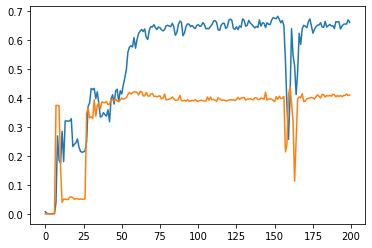

In [39]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()


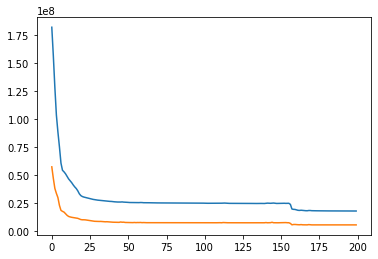

In [40]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_squared_error',
metrics=['accuracy'])


In [42]:
import matplotlib.pyplot as plt

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=200, batch_size=None, validation_split=0.1)

Epoch 1/200
7/7 [==============================] - 1s 61ms/step - loss: 159327488.0000 - accuracy: 0.0165 - val_loss: 37956840.0000 - val_accuracy: 0.0037
Epoch 2/200
7/7 [==============================] - 0s 31ms/step - loss: 97149320.0000 - accuracy: 0.0210 - val_loss: 30572572.0000 - val_accuracy: 0.0181
Epoch 3/200
7/7 [==============================] - 0s 30ms/step - loss: 84165240.0000 - accuracy: 0.0937 - val_loss: 28966486.0000 - val_accuracy: 0.0482
Epoch 4/200
7/7 [==============================] - 0s 29ms/step - loss: 79387216.0000 - accuracy: 0.2176 - val_loss: 25898466.0000 - val_accuracy: 0.0493
Epoch 5/200
7/7 [==============================] - 0s 30ms/step - loss: 73201312.0000 - accuracy: 0.2202 - val_loss: 25939896.0000 - val_accuracy: 0.0419
Epoch 6/200
7/7 [==============================] - 0s 30ms/step - loss: 71876848.0000 - accuracy: 0.2172 - val_loss: 25905096.0000 - val_accuracy: 0.0418
Epoch 7/200
7/7 [==============================] - 0s 32ms/step - loss: 711

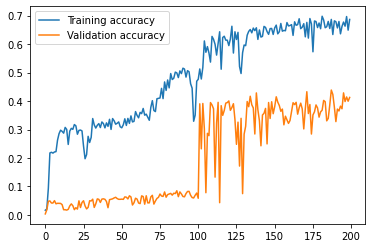

In [45]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()

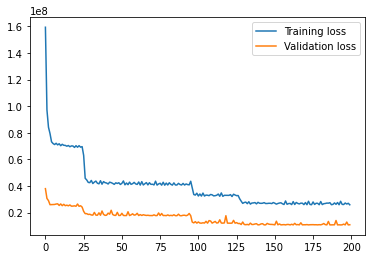

In [46]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()